# Understanding predictors of blood pressure in US adults using kernel ridge regression

Kernel ridge regression (KRR) is a nonparametric regression technique.  KRR has the potential to identify non-additive and non-linear conditional mean structures automatically, without needing to specify a regression formula or test a large set of models to identify the one that fits best.  To use KRR we specify a positive semidefinite kernel function, and a regularization parameter $\lambda \ge 0$.

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import eigsh
from read import df

We will use KRR to explain the variation in SBP in terms of the covariates in 'vx' below.

In [2]:
vx = ["RIAGENDR", "RIDAGEYR", "BMXWT", "BMXHT", "BMXBMI", "BMXLEG",
      "BMXARML", "BMXARMC", "BMXWAIST", "BMXHIP"]
vn = ["BPXSY1"] + vx

In [3]:
dx = df.loc[:, vn].dropna()

Recode everything as numeric, convert to numpy arrays.

In [4]:
dx["RIAGENDRx"] = dx.RIAGENDR.replace({"F": 1, "M": -1})
vxx = ["RIAGENDRx" if x == "RIAGENDR" else x for x in vx]
X = dx[vxx].values
y = dx["BPXSY1"].values

Standardize all variables (this is not essential but makes the results easier to interpret, and makes the algorithm easier to train).

In [5]:
xmn = X.mean(0)
X -= xmn
xsd = X.std(0)
X /= xsd
ymn = y.mean()
y -= ymn
ysd = y.std()
y /= ysd

Fit a linear model using OLS for comparison.

In [6]:
u, s, vt = np.linalg.svd(X, 0)
yh = np.dot(u, np.dot(u.T, y))
rmse_ols = np.sqrt(np.mean((y - yh)**2))
rmse_ols

0.8587143715619618

A key component of kernel ridge regression is a kernel function, that is used to measure the similarity between two observations based on their covariate vectors.  Two of the most common kernels are the squared exponential kernel (a radial basis kernel), and the polynomial kernel.

In [7]:
def ker_sqexp(X, scale, Y=None):
    """Squared exponential kernel with a given scale parameter."""
    if Y is None:
        Y = X
    D = cdist(X, Y)
    return np.exp(-D**2 / (2*scale**2))

In [8]:
def ker_poly(X, c=1, p=2, Y=None):
    """Polynomial kernel with given interept and power parameters."""
    if Y is None:
        Y = X
    G = np.dot(X, Y.T)
    return (G + c)**p

Plot the RMSE for various regularization parameters and kernels, using independent subsets of data for training and validation.

In [9]:
def goodness_of_fit(kers, lams, labels, ti):
    plt.clf()
    plt.figure(figsize=(7, 4))
    plt.axes([0.12, 0.12, 0.67, 0.8])
    plt.grid(True)

    # Split into training and testing sets.
    ii = np.random.permutation(X.shape[0])
    X1 = X[ii[0:2000], :]
    y1 = y[ii[0:2000]]
    X2 = X[ii[2000:], :]
    y2 = y[ii[2000:]]
    
    # Sweep out a range of kernels.
    for j,ker in enumerate(kers):
        K1 = ker(X1)
        S, B = np.linalg.eigh(K1)
        Bty = np.dot(B.T, y1)
        K2 = ker(X2, Y=X1)
        
        # Calculate the RMSE for models with different
        # degrees of regularization.
        rmse = []
        for lam in lams:
            alpha_hat = np.dot(np.dot(B, np.diag(S/(S**2 + lam))), Bty)
            yhat = np.dot(K2, alpha_hat)
            e = np.sqrt(np.mean((y2 - yhat)**2))
            rmse.append(e)
        plt.plot(lams, rmse, "-", label=labels[j])

    plt.title(ti)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)
    leg.set_title("Kernel scale")
    plt.xlabel("Regularization", size=15)
    plt.ylabel("RMSE", size=15)
    plt.show()

To illustrate the fitted models, plot the fitted values for females and males, using the given kernel and regularization parameters.

In [21]:
def plot_fit(ker, lam):

    ii = np.random.permutation(X.shape[0])
    X1 = X[ii[0:2000], :] # for speed
    y1 = y[ii[0:2000]]
    
    K = ker(X1)
    S, B = np.linalg.eigh(K)
    alpha_hat = np.dot(np.dot(B, np.diag(S/(S**2 + lam))), np.dot(B.T, y1))

    females = np.flatnonzero(X1[:, 0] > 0)
    males = np.flatnonzero(X1[:, 0] < 0)

    ages = np.linspace(18, 80, 50)
    ages_std = (ages - xmn[1]) / xsd[1]
    Xp = np.zeros_like(X[0:100, :])
    Xp[0:50, 0] = X1[females[0], 0]
    Xp[50:, 0] = X1[males[0], 0]
    Xp[0:50, 1] = ages_std
    Xp[50:, 1] = ages_std

    Kp = ker(X1, Y=Xp)
    yhat = np.dot(Kp.T, alpha_hat)
    yhat = ymn + ysd * yhat

    plt.clf()
    plt.axes([0.12, 0.12, 0.7, 0.8])
    plt.grid(True)
    plt.plot(ages, yhat[0:50], "-", color="purple", label="Female")
    plt.plot(ages, yhat[50:100], "-", color="orange", label="Male")
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)
    plt.title("regularization=%.2f" % lam)
    plt.xlabel("Age", size=15)
    plt.ylabel("SBP", size=15)
    plt.show()

Consider goodness of fit for KRR using squared exponential kernels.

<Figure size 640x480 with 0 Axes>

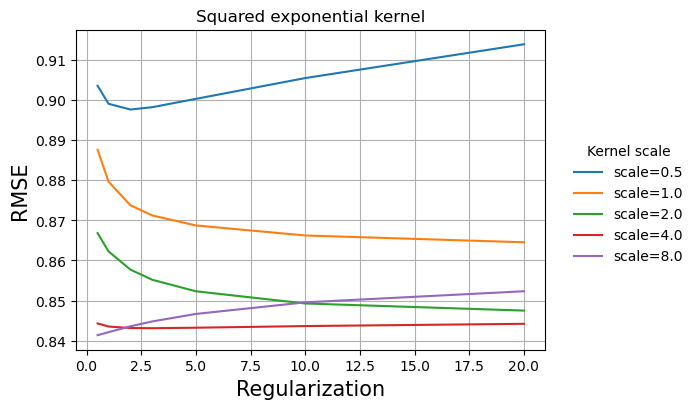

In [12]:
scales = [0.5, 1, 2, 4, 8]
lams = [0.5, 1, 2, 3, 5, 10, 20]

kers = [lambda X, scale=scale, Y=None: ker_sqexp(X, scale=scale, Y=Y) for scale in scales]
labels = ["scale=%.1f" % x for x in scales]

goodness_of_fit(kers, lams, labels, "Squared exponential kernel")

Consider goodness of fit for KRR using polynomial kernels.

<Figure size 640x480 with 0 Axes>

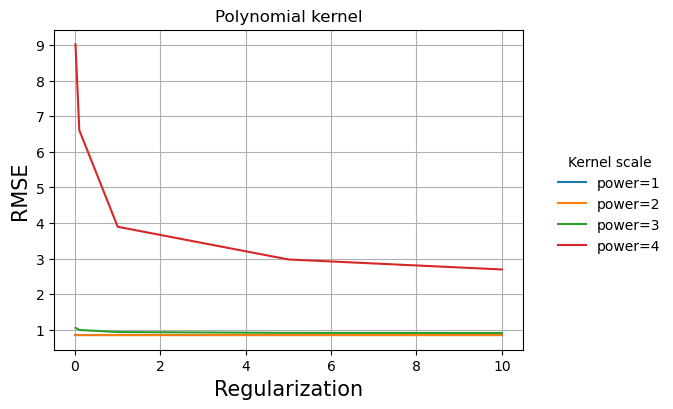

In [13]:
pows = [1, 2, 3, 4]
kers = [lambda X, p=p, Y=None: ker_poly(X, c=0.5, p=p, Y=Y) for p in pows]
labels = ["power=%d" % p for p in pows]
goodness_of_fit(kers, [0.01, 0.1, 1, 5, 10], labels, "Polynomial kernel")

Below we plot estimated conditional mean blood pressure as a function of age and sex, holding all other variables in the model fixed at their mean values.  These fits use squared exponential kernels.

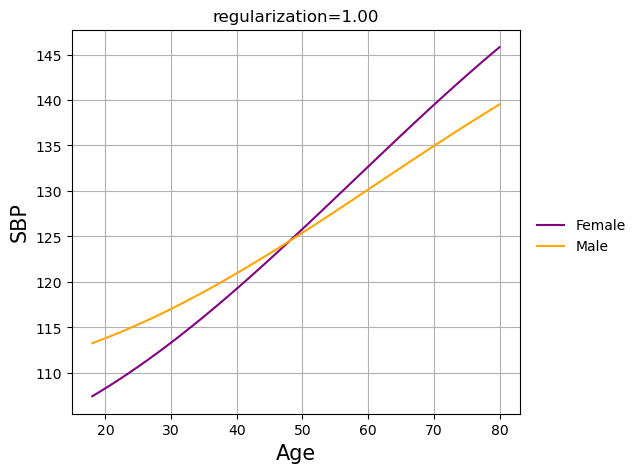

In [22]:
for scale in [4]:
    for lam in [1]:
        plot_fit(lambda X, scale=scale, Y=None: ker_sqexp(X, scale=scale, Y=Y), lam)

Here we plot conditional mean blood pressure given age and sex, holding all other variables fixed, but now using polynomial kernels.

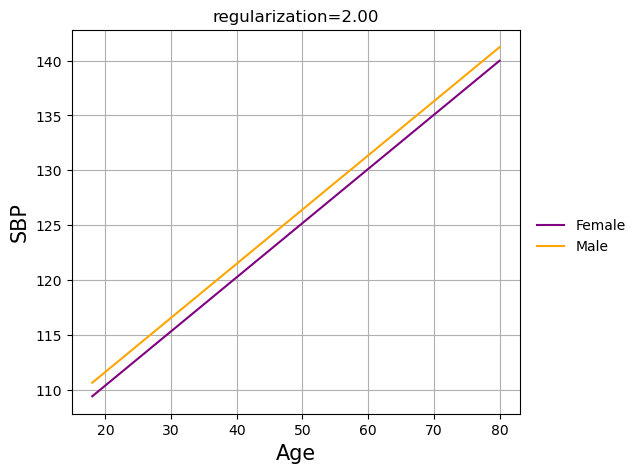

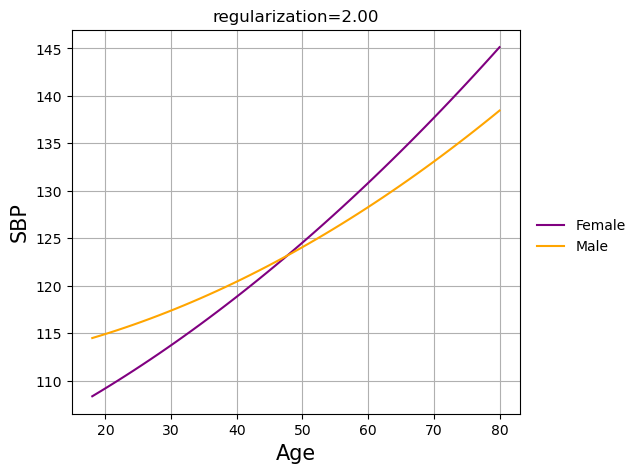

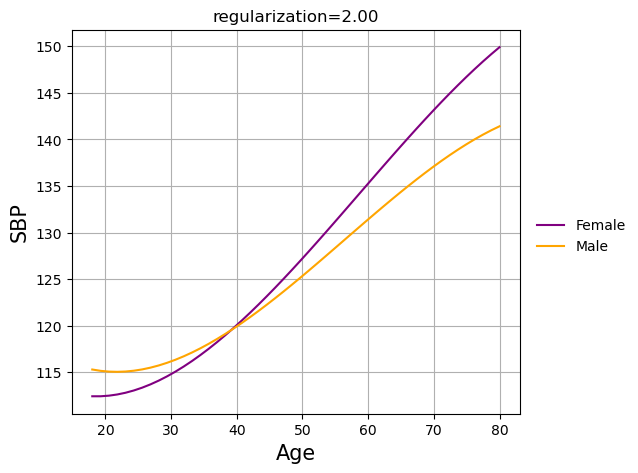

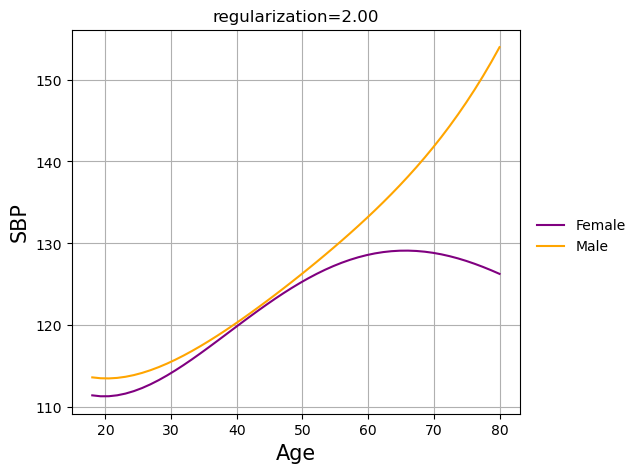

In [25]:
for p in [1, 2, 3, 4]:
    for lam in [2]:
        plot_fit(lambda X, p=p, Y=None: ker_poly(X, p=p, Y=Y), lam)